<p style="color:#e8574d; font-size:30px; font-weight:bold; font-family:Helvetica"> Content </p>

<ul style="font-size:16px; font-family:Helvetica">
    <li><a href='#copyright' style="color:#696969; text-decoration: none">Copyright and License</a></li>
    <li><a href='#modules' style="color:#696969; text-decoration: none">All Necessary Modules and Datasets</a></li>
    <li><a href='#eda' style="color:#696969; text-decoration: none">Exploratory Data Analysis</a></li>
    <li><a href='#timer' style="color:#696969; text-decoration: none">Time Complexity: Big Bird and Transformers</a></li>
    <li><a href='#cited' style="color:#696969; text-decoration: none">Reference</a></li>
</ul> 



<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Copyright and License<a id='copyright'></a></p>

<p style="color:#696969; font-size:14px">License and copyright notice</p>

In [1]:
!pip show bigbird

Name: bigbird
Version: 0.0.1
Summary: Big Bird: Transformers for Long Sequences
Home-page: http://github.com/google-research/bigbird
Author: Google Inc.
Author-email: no-reply@google.com
License: Apache 2.0
Location: /opt/anaconda3/lib/python3.8/site-packages
Requires: absl-py, natsort, numpy, rouge-score, sentencepiece, tensor2tensor, tensorflow, tensorflow-text, tfds-nightly
Required-by: 


<p style="color:#696969; font-size:14px; margin:0px; padding:0px">State changes:</p>
<p style='font-family:monospace; margin-left:20px'>Name:</p>

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">All Necessary Modules and Datasets<a id='module'></a></p>

In [2]:
# Transformers and BigBird
import tensorflow as tf
from summarizer import Summarizer,TransformerSummarizer

# Reading and manipulate NLP data
import math
import numpy as np
from nltk.corpus import words
import pandas as pd
from random import sample
import re
import tensorflow.compat.v2 as tf
from tqdm import tqdm

# Plot
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Evaluate metrics
from rouge_score import rouge_scorer
import time

# Tensorflow dataset
import tensorflow_datasets as tfds
import tensorflow_text as tft

In [3]:
# Clean text up
def clean_up_text(thedict):
    for i in range(len(thedict['abstract_text'])):
        # Remove all <S> and </S> and double spaces and ", " in abstract text
        thedict['abstract_text'][i] = re.sub(' +', ' ', thedict['abstract_text'][i].replace('<S>','').replace(
        '</S>','').replace('", "',''))
        thedict['article_text'][i] = re.sub(' +', ' ', thedict['article_text'][i].replace(
            '", "','').replace('["',''))
    return thedict

# Create reading arxiv data for this particular txt problem
def read_arxiv_data(directory):
    with open(directory) as f: # read lines
        lines = f.readlines()
    article_id = []            # Instantiate empty lists
    article_text = []
    abstract_text = []
    for i in range(len(lines)): # for loop to find start and end strings
        article_id.append(lines[i][lines[i].find('"article_id": "')+len(
        '"article_id": "'):lines[i].find('",')])
        article_text.append(lines[i][lines[i].find('"article_text": ')+len(
        '"article_text": '):lines[i].find('"], ')])
        abstract_text.append(lines[i][lines[i].find('"abstract_text": ["<S>')+len(
            'abstract_text": ["<S>  '):lines[i].find(' </S>"]')])
    thedict = {'article_id':article_id,'article_text':article_text,'abstract_text':abstract_text} 
    return clean_up_text(thedict) # Use clean up tool 

In [4]:
# Read validation set
result = read_arxiv_data('arxiv-dataset/val.txt')

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Exploratory Data Analysis<a id='eda'></a></p>

In [5]:
np.random.seed(121)
r = int(np.random.choice(range(len(result['article_id'])), size=1))

In [6]:
print(result['article_id'][r])

1011.3627


In [7]:
print(result['abstract_text'][r])

we report results of fully non - perturbative calculations , based on auxiliary field quantum monte carlo ( afqmc ) approach , for the dilute neutron matter at the density @xmath0 . fundamental quantities which characterize the superfluid state : the single particle energy gap @xmath1 , and the critical temperature @xmath2 have been determined . the large value of @xmath3 indicates that the system is not a bcs - type superfluid at low temperatures .


In [8]:
print(result['article_text'][r])

although a homogeneous neutron matter is one of the simplest nuclear systems , its importance can not be overemphasized since it constitutes the main component of neutron stars .the density of the neutron matter forming neutron stars ranges from subnuclear densities ( in the inner crust ) up to extremely high values of @xmath4 ( expected in the center of the star ) , where @xmath5 is the saturation density@xcite . in the regime of sufficiently low densitiesone can perform very precise calculations since the neutron - neutron interaction is completely dominated by the scattering in @xmath6 channel , which is determined by two parameters only : the scattering length @xmath7 and the effective range @xmath8 .indeed , at the densities @xmath9 ( @xmath10 ) the influence of other channels as well as of three - body forces is marginal and can be neglected@xcite .the values of the scattering length and the effective range are well known from the low energy scattering experiments and read : @xma

In [9]:
# Create the Standard Scaler for dictionary
def z_score(thedict):
    if type(thedict) == type({}): # If dict type
        adict = thedict.copy()
        thedict = list(thedict.values())
    else:
        adict = None
    u = np.mean(thedict)
    s = np.std(thedict)
    x = thedict
    Z = (x - u)/s
    if type(adict) == type({}): # If dict type
        # Instantiate i
        i = 0
        for k in adict.keys():
            adict[k] = Z[i]
            i+=1 
        return adict
    else:             # If not dict type
        return Z

In [10]:
# Check for abstract text sampling convergence
convergence = {}
for i in range(10,3000):
    sampling = sample(result['abstract_text'],i)
    convergence[i] = sum(map(len, sampling))/float(len(sampling))
convergence = z_score(convergence)
# Check for article text sampling convergence
convergence1 = {}
for i in range(10,3000):
    sampling = sample(result['article_text'],i)
    convergence1[i] = sum(map(len, sampling))/float(len(sampling))
convergence1 = z_score(convergence1)

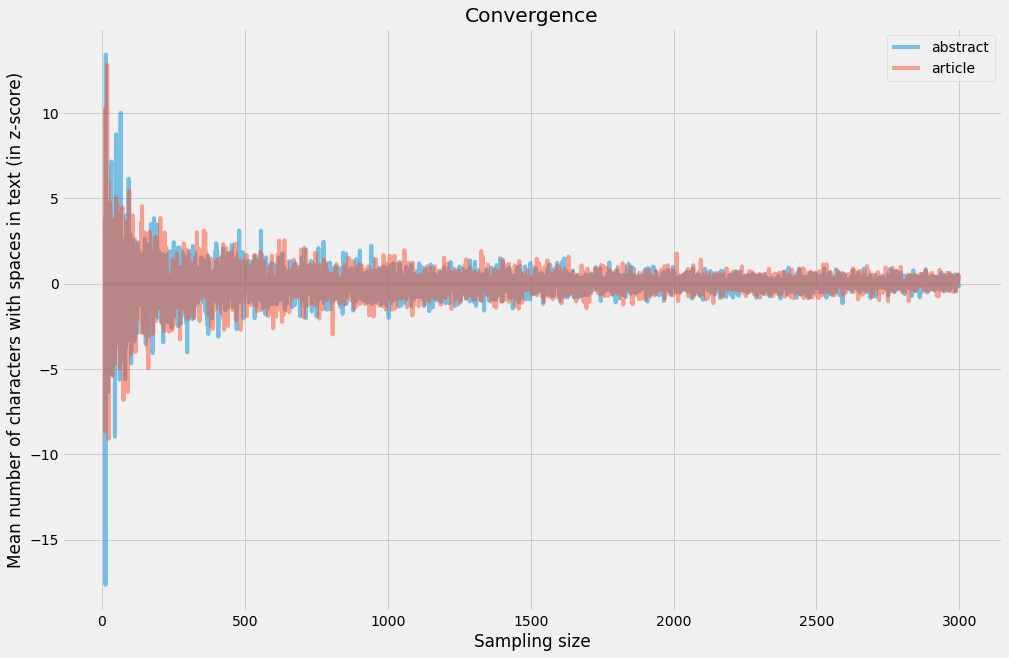

In [11]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,10))
plt.plot(convergence.keys(),convergence.values(),alpha=0.5,label = 'abstract')
plt.plot(convergence1.keys(),convergence1.values(),alpha=0.5, label = 'article')
plt.xlabel('Sampling size')
plt.ylabel('Mean number of characters with spaces in text (in z-score)')
plt.title('Convergence')
plt.legend()
plt.show()

In [12]:
# Select 1500 sampling size
sampling = sample(result['abstract_text'],1500)
sampling1 = sample(result['article_text'],1500)

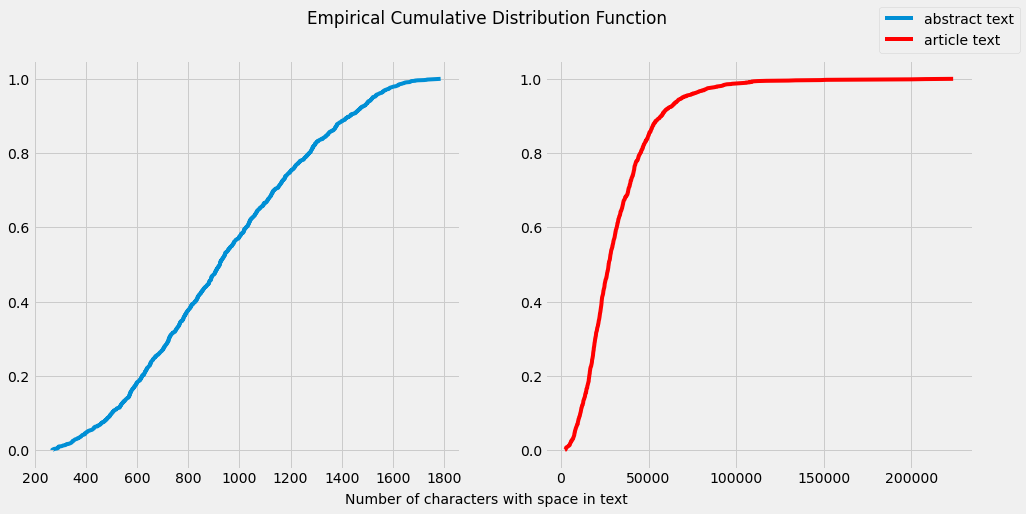

In [13]:
ecdf = ECDF(list(map(len,sampling)))
ecdf1 = ECDF(list(map(len,sampling1)))

# plot the ecdf
fig, ax = plt.subplots(1,2,figsize = (15,7))
ax[0].plot(ecdf.x, ecdf.y, label = 'abstract text')
ax[1].plot(ecdf1.x, ecdf1.y, color = 'red', label = 'article text')
fig.suptitle('Empirical Cumulative Distribution Function')
fig.text(0.5, 0.00, 'Number of characters with space in text', ha='center')
fig.legend()
plt.show()

In [14]:
def str_info(thelist):
    print('length of text')
    print('mean:', round(sum(map(len,thelist))/len(thelist),2))
    print('median:', round(np.median(list(map(len,thelist))),2))
    print('stdev:', round(np.std(list(map(len,thelist))),2))
    print('0.975:', round(np.quantile(list(map(len,thelist)),0.975),2))
    print('0.025:', round(np.quantile(list(map(len,thelist)),0.025),2))

In [15]:
str_info(sampling)

length of text
mean: 943.48
median: 923.0
stdev: 341.39
0.975: 1586.52
0.025: 349.95


In [16]:
str_info(sample(result['article_text'],1500))

length of text
mean: 31990.08
median: 26911.5
stdev: 21120.43
0.975: 86479.77
0.025: 5938.5


In [17]:
def english_match(alist):
    thelist = [] # instantiate list
    for i in range(len(alist)):  # tokenize
        thelist.extend(alist[i].split())
    # Apply numpy for more efficiency and check if tokenizer matches dictionary
    # and set the benchmark for english percentage
    return str(round(100*np.mean(np.isin(np.array(thelist),
           np.array(words.words())).astype(int)),2))+'%'

In [18]:
print('The percentage of abstract texts that matches NLTK dictionaries:',
      english_match(sample(result['abstract_text'],1500)))
print('The percentage of article texts that matches NLTK dictionaries:',
      english_match(sample(result['article_text'],100)))

The percentage of abstract texts that matches NLTK dictionaries: 70.8%
The percentage of article texts that matches NLTK dictionaries: 62.05%


<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Review on Transformers and Big Bird under the Hood<a id='hood'></a></p>

<p style="color:#696969; font-size:14px">Transformers</p>

<img src='https://github.com/jonahwinninghoff/Text-Summarization/raw/main/Images/Transformers%20Architecture.png'/>

<p style="color:#696969; font-size:14px; text-align: justify">The left side of transfomers is encoder and another side decoder. Both encoder and decoder absorb information from word embeddings processed by word2vec. The difference is that the representation of encoder is X while the representation of decoder is Z (Vaswani et al., 2017). For this analysis, the representation of encoder is word embedding of <i>article_text</i> that of decoder word embedding of <i>abstract_text</i>.</p>

<img src='https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/Attention-formula.png?raw=true'/>

<p style="color:#696969; font-size:14px;text-align: justify">The self attention is also known as scaled dot-product attention, which is associated with multi-head attention. The K represents of keys while the V represents values. The Q is a matrix of a set of queries. The query refers to particular word that has has posed (i.e., "You") while the key refer to next word (i.e., "have"). The d<sub>k</sub> is the key dimensionality. The softmax is a generalization of logistic function.</p>

<img src='https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/head_i.png?raw=true'/>

<p style="color:#696969; font-size:14px">The head<sub>i</sub> is with a vector of Q, K, and V matrically multiplied by a vector of weights</p>

<img src = 'https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/multi-head-attention.png?raw=true'/>

<p style="color:#696969; font-size:14px">The multi-head attention is a concatenation of head_i multiplied by a weight (Vaswani et al., 2017).</p>

<p style="color:#696969; font-size:14px">Big Bird</p>

<p style="color:#696969; font-size:14px;text-align: justify">The Big Bird algorithm is almost identical to transformers but what is changed in this algorithm is that block sparse attention is in use. The objective in this algorithm is to ensure that algorithm is more efficient using three different connections instead of normal attention that relies on full connection. These connections are global, sliding, and random. For example:</p>

<img src = 'https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/Block%20Sparse.png?raw=true' />

<img src = 'https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/Compare%20attentions.png?raw=true' />

<img src='https://github.com/jonahwinninghoff/Text-Summarization/blob/main/Images/bird%20view.png?raw=true'/>

<p style="color:#696969; font-size:14px">(Gupta, 2021)</p>

<p style="color:#696969; font-size:14px;text-align: justify">Both figures are pretty self-explained. However, the Big Bird creators claim that this algorithm is linear dependence for sequence. This is why this analysis is to evaluate to determine if this claim is true.</p>

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Time Complexity: Big Bird and Transformers<a id='timer'></a></p>

In [19]:
# Create new column for word counts
result['abstract word counts'] = [len(result['abstract_text'][0].split())]
for i in range(1,len(result['article_id'])):
    result['abstract word counts'].append(len(result['abstract_text'][i].split()))

In [20]:
# Develop complete assessment on Transformer text summarization
def assess_transf(data,size_of_sampling = 100, seed = 0, warning = False):
    thelist = {} # Instantiate the list in dict form
    
    # Instantiate the Transformer Summarizer and rouge scorer
    model = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    
    # Set seed and use size_of_sampling for tuning
    np.random.seed(seed)
    r = np.random.choice(range(len(data['article_id'])), size = size_of_sampling, replace = False)
    
    # Instantiate all variables for dict append
    thelist['article_id'] = []
    thelist['article_text'] = []
    thelist['abstract_text'] = []
    thelist['article word counts'] = []
    thelist['abstract word counts'] = []
    thelist['predicted summary'] = []
    thelist['predicted summary word counts'] = []
    thelist['time in seconds'] = []
    thelist['rouge1'] = []
    thelist['rouge2'] = []
    thelist['rougeL'] = []
    
    # for loop based on size_of_sampling
    for i in range(size_of_sampling):
        # Get data
        thelist['article_id'].append(data['article_id'][r[i]])
        thelist['article_text'].append(data['article_text'][r[i]])
        thelist['article word counts'].append(len(data['article_text'][r[i]].split()))
        thelist['abstract_text'].append(data['abstract_text'][r[i]])
        thelist['abstract word counts'].append(data['abstract word counts'][r[i]])
        
        # Predict summaries with start timer
        start = time.time()
        auto = ''.join(model(data['article_text'][r[i]], 
                             max_length=data['abstract word counts'][r[i]]+20))
        thelist['predicted summary'].append(auto)
        thelist['time in seconds'].append(time.time()-start)
        thelist['predicted summary word counts'].append(len(auto.split()))
        
        # Create score for each summary using rouge as a set of metrics
        scores = scorer.score(data['abstract_text'][r[i]],auto)
        thelist['rouge1'].append(scores['rouge1'][2])
        thelist['rouge2'].append(scores['rouge2'][2])
        thelist['rougeL'].append(scores['rougeL'][2])
    
    return pd.DataFrame(thelist)

In [21]:
# Develop complete assessment on Transformer text summarization
def assess_bigbir(dict_data,size_of_sampling = 1, seed = 0, warning = False):
    tf.enable_v2_behavior()
    
    # Instantiate the list
    thelist = {}
    
    # Check if dict data type
    if type(dict_data) == type({}):
        # Count words in each article text
        dict_data['article word counts'] = [len(dict_data['article_text'][0].split())]
        for i in range(1,len(result['article_id'])):
            dict_data['article word counts'].append(len(dict_data['article_text'][i].split()))
            
        # Form this data into pandas dataframe
        df = pd.DataFrame(dict_data)
        
        # Set seed and use size_of_sampling for tuning and randomly sample some of data
        np.random.seed(seed)
        r = np.random.choice(range(len(dict_data['article_id'])), size = size_of_sampling, replace = False)
        df = df.iloc[r,:]
        df.reset_index(drop=True, inplace=True) # Reset index
        
        # Random sampling on pandas and form another data called TensorSliceDataset using smaller data
        dataset = tf.data.Dataset.from_tensor_slices(df[['article_id','article_text','abstract_text']])

        # Instantiate the Big Bird Summarizer and rouge scorer
        import warnings
        warnings.filterwarnings('ignore')

        path = 'gs://bigbird-transformer/summarization/pubmed/roberta/saved_model'
        imported_model = tf.saved_model.load(path, tags='serve')
        summarize = imported_model.signatures['serving_default']
        scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
        
        # Instantiate all variables for dict append
        thelist['predicted summary'] = []
        thelist['predicted summary word counts'] = []
        thelist['time in seconds'] = []
        thelist['rouge1'] = []
        thelist['rouge2'] = []
        thelist['rougeL'] = []
        
        ## for loop based on size_of_sampling 
        for ex in tqdm(dataset.take(size_of_sampling), position=0):
            start = time.time() # timer
            predicted_summary = summarize(ex[2])['pred_sent'][0] # prediction
            thelist['time in seconds'].append(time.time()-start) # end timer
            score = scorer.score(ex[2].numpy().decode('utf-8'), predicted_summary.numpy().decode('utf-8')) # scores
            thelist['predicted summary'].append(predicted_summary.numpy().decode('utf-8')) # summary
            thelist['predicted summary word counts']= len(predicted_summary.numpy().decode('utf-8').split()) # counts
            thelist['rouge1'].append(score['rouge1'][2]) # rouge1
            thelist['rouge2'].append(score['rouge2'][2]) # rouge2
            thelist['rougeL'].append(score['rougeL'][2]) # rougeL
            
        return pd.concat([df, pd.DataFrame(thelist)],axis=1)
        
    else:
        print('Please use dictionary data type.')

In [22]:
rouges = assess_bigbir(result,size_of_sampling = 110, seed = 33, warning = False)

100%|██████████| 110/110 [48:45:34<00:00, 1595.77s/it]  


In [23]:
transformer = assess_transf(result, size_of_sampling = 110, seed = 33)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
rouges['block sparsity'] = 1
transformer['block sparsity'] = 0

In [25]:
pd.concat([rouges, transformer],axis=0).to_csv('bigbirvtrans')

In [26]:
pd.concat([rouges, transformer],axis=0)

,article_id,article_text,abstract_text,abstract word counts,article word counts,predicted summary,predicted summary word counts,time in seconds,rouge1,rouge2,rougeL,block sparsity
0,1106.0419,the dynamics of opinion formation in a society...,we present here the exact solution of an infin...,110,6240,we present the exact solution of the exact sol...,69,1548.404512,0.556962,0.435897,0.518987,1
1,cond-mat0203463,vehicular traffic on highways as well as in ci...,a two dimensional cellular automaton is introd...,106,6463,two dimensional cellular automaton is introduc...,69,1552.549365,0.862559,0.822967,0.853081,1
2,astro-ph0011497,studies of individual stars and resolved stell...,we have used an updated version of the empiric...,140,7220,we have used an empirically and semi - empiric...,69,1551.974925,0.589474,0.457447,0.536842,1
3,1211.1117,"traditionally , gamma - ray bursts ( grbs ) ar...",traditionally gamma - ray bursts ( grbs ) are ...,240,5733,avaialble ( grb ) is a global gamma - ray burs...,69,1537.593251,0.383333,0.089385,0.266667,1
4,nlin0103014,the standard approach to description of spatia...,very narrow spatial bright solitons in ( 1 + 1...,116,4119,the solitons in ( 1 + 1)d and ( 2 + 1)d versio...,69,1543.431132,0.748858,0.672811,0.712329,1
...,...,...,...,...,...,...,...,...,...,...,...,...
105,astro-ph9906149,evolutionary population synthesis predictions ...,a self - consistent spectrophotometric modelli...,125,1799,"1998 ) , and an instantanous bolometric correc...",35,0.868915,0.138889,0.014085,0.097222,0
106,quant-ph0201120,discrete orthogonal transforms and discrete un...,a quantum computer directly manipulates inform...,122,5648,"for example , consider the circuit in figure [...",40,1.415362,0.172662,0.029197,0.143885,0
107,1601.01296,two - particle correlations in azimuthal angle...,two - particle pseudorapidity correlations are...,202,1760,what are their sizes and distribution in the t...,36,2.277386,0.164251,0.048780,0.135266,0
108,astro-ph0303393,the exciting evidence for evolution in distant...,radio continuum emission at 1.4 ghz was used t...,233,1896,"using this sample, we ask the question : do an...",64,1.852807,0.251852,0.029851,0.140741,0


<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Useful Reference<a id='cited'></a></p>

- https://huggingface.co/blog/big-bird
- https://www.tensorflow.org/datasets/catalog/scientific_papers
- http://github.com/google-research/bigbird
- https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf